In [148]:
import pandas as pd
import numpy as np
import os
CWD = "/".join(os.getcwd().split("/")[:-2])

from astropy.units import parallax
import astropy.units as u

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

import matplotlib.pyplot as plt

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

In [144]:

from astropy.constants import R_sun
def calculate_inclination(s):
    """Determine the inclination
    vsini, stellar radius, and rotation
    period.
    
    Parameters:
    -----------
    s : pandas Series
        contains "rad", "rad_err", "Prot_d",
        "vsini_kms", and "e_vsini_kms". No uncertainties
        on "P".
    
    Return:
    -------
    inclination, uncertainty on inclination - 
        astropy Quantities
    """
    R, P, vsini = s.rad * R_sun, s.Prot_d * u.d, s.vsini_kms * u.km / u.s
    eR, eP, evsini = s.rad_err * R_sun, 1./24/30 * u.d, s.e_vsini_kms * u.km / u.s

    sini = vsini * P / 2. / np.pi / R
    v = vsini / sini
    print(f"sin(i)={sini.decompose():.2f}")
    incl = np.arcsin(sini)
    print(incl)
    t1 = vsini * P / (2. * np.pi * R**2) * eR
    t2 = P / (2. * np.pi * R) * evsini
    t3 = vsini / (2. * np.pi * R) * eP
    esini = np.sqrt(t1**2 + t2**2 + t3**2) *u.rad
    
    if incl-np.pi/2*u.rad<1e-3*u.rad:
        eincl = 1/np.sqrt(2) / np.sqrt(1 + sini) * esini
    else:
        eincl = 1 / np.sqrt(1- sini**2) * esini

    return incl.to("deg"), eincl.to("deg"), sini.decompose().value, esini.decompose().value


In [145]:
%matplotlib inline
lcs = pd.read_csv(f"{CWD}/data/summary/lcsvsini.csv")

props = pd.read_csv(f"{CWD}/data/summary/properties.csv")

lcs = lcs.merge(props, left_on="ID", right_on="id")
lcs = lcs.set_index("ID")
lcs = lcs.dropna(subset=["vsini_kms"])
lcs = lcs[lcs.index!=230120143]
lcs

,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,view_stop,...,tfluxerr,tlum,tlumerr,kflux,kfluxerr,klum,klumerr,gmag,jmag,kmag
ID,,,,,,,,,,,,,,,,,,,,,
100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,1361.00,...,1.937460e-13,1.119535e+29,6.553810e+27,6.712990e-13,4.272880e-14,2.263849e+28,1.444680e+27,17.8356,13.078,11.771
237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,1333.50,...,2.211940e-12,8.870689e+30,5.645140e+29,1.272670e-11,6.844750e-13,3.232358e+30,1.750110e+29,14.9796,11.530,10.636
44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,1589.75,...,4.378460e-12,9.308451e+29,6.480260e+28,2.018160e-11,1.412120e-12,2.979395e+29,2.089910e+28,14.4115,10.309,9.268
277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,1643.50,...,4.613440e-12,1.126370e+30,1.051740e+29,1.380730e-11,1.517240e-12,3.103479e+29,3.444490e+28,14.7381,10.630,9.666


100004076 0.9987210026458961 0.08352276517894512
sin(i)=0.76
0.8594593230103518 rad
49.243391871664116 deg 4.597736060604638 deg 

237880881 0.7574896942155789 0.15044674477109055
sin(i)=0.36
0.3718561470554695 rad
21.305787812274495 deg 2.306479743752094 deg 

44984200 0.3633453446951738 0.0664729495865361
sin(i)=0.55
0.5784518070098337 rad
33.14284719337948 deg 1.6336741567552868 deg 

277539431 0.546728274918496 0.05014929322819704
sin(i)=1.00
1.5202143124781726 rad
87.10186406038142 deg 2.39351641669415 deg 



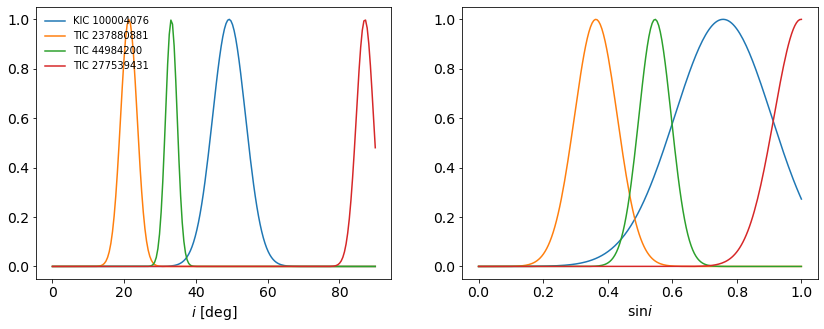

In [150]:
#lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
for l, target in lcs.iterrows():
    print(l, sini, esini)
    i_mu, i_sigma, sini, esini= calculate_inclination(target)
    #i_mu, i_sigma = i_mu.to("rad").value, i_sigma.to("rad").value
    print(i_mu, i_sigma, "\n")
    x = np.linspace(0,1,200)
    axs[1].plot(x,
             gaussian(x, sini, esini),)
    axs[1].set_xlabel(r"$\sin i$", fontsize=14)
    x = np.linspace(0,np.pi/2,200)
    axs[0].plot(x/np.pi*180.,
             gaussian(x, i_mu.to("rad").value, i_sigma.to("rad").value),
             label=f"{target.prefix} {l}")
    axs[0].set_xlabel(r"$i$ [deg]", fontsize=14)
axs[0].legend(loc=2, frameon=False)
plt.savefig("/home/ekaterina/Documents/002_writing/multiperiod-flares-draft/figures/inclination.png",dpi=300)

In [147]:

lcs["i_mu"] = lcs.apply(lambda x: calculate_inclination(x)[0].to("rad").value, axis=1)
lcs["i_sigma"] = lcs.apply(lambda x: calculate_inclination(x)[1].to("rad").value, axis=1)
lcs

sin(i)=0.76
0.8594593230103518 rad
sin(i)=0.36
0.3718561470554695 rad
sin(i)=0.55
0.5784518070098337 rad
sin(i)=1.00
1.5202143124781726 rad
sin(i)=0.76
0.8594593230103518 rad
sin(i)=0.36
0.3718561470554695 rad
sin(i)=0.55
0.5784518070098337 rad
sin(i)=1.00
1.5202143124781726 rad


,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,view_stop,...,tlumerr,kflux,kfluxerr,klum,klumerr,gmag,jmag,kmag,i_mu,i_sigma
ID,,,,,,,,,,,,,,,,,,,,,
100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,1361.00,...,6.553810e+27,6.712990e-13,4.272880e-14,2.263849e+28,1.444680e+27,17.8356,13.078,11.771,0.859459,0.080246
237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,1333.50,...,5.645140e+29,1.272670e-11,6.844750e-13,3.232358e+30,1.750110e+29,14.9796,11.530,10.636,0.371856,0.040256
44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,1589.75,...,6.480260e+28,2.018160e-11,1.412120e-12,2.979395e+29,2.089910e+28,14.4115,10.309,9.268,0.578452,0.028513
277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,1643.50,...,1.051740e+29,1.380730e-11,1.517240e-12,3.103479e+29,3.444490e+28,14.7381,10.630,9.666,1.520214,0.041775


In [97]:
lcs.to_csv(f"{CWD}/data/summary/lcsi.csv")

In [143]:
(1/8.3 - 1/8.4)*24*30


1.032702237521509